In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/raw.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive')

In [4]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 88.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.6 MB/s eta 0:00:00


In [5]:
!pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.8 MB/s eta 0:00:00


In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.utils import resample
import underthesea
from underthesea import word_tokenize
import re
from deep_translator import GoogleTranslator
import time
from concurrent.futures import ThreadPoolExecutor


# **A. Exploratory Data Analysis**

## **I. Load Datasets**

In [7]:
train_set = pd.read_csv("/content/drive/MyDrive/raw/train.csv")
dev_set = pd.read_csv("/content/drive/MyDrive/raw/dev.csv")
test_set = pd.read_csv("/content/drive/MyDrive/raw/test.csv")

In [8]:
train_set

,free_text,label_id
0,Em được làm fan cứng luôn rồi nè ❤️ reaction q...,0
1,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...,2
2,Đậu Văn Cường giờ giống thằng sida hơn à,0
3,CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...,2
4,Từ lý thuyết đến thực hành là cả 1 câu chuyện ...,0
...,...,...
24043,Thả tim cho sự cống hiến của ngài,0
24044,Thua !,0
24045,Ở Việt Nam thì có khánh sky..hải ngoại có trần...,0
24046,"1:22 ai lớp du chu cờ moo, Duyên dáng quá cô ơi",0


In [9]:
dev_set

,free_text,label_id
0,Coi cười xỉu,0
1,Chi ba vang ngoc dep va tre mai,0
2,"Chần vần một đống, không ai đoán trước được đừ...",0
3,Du học sinh Úc mà lại,0
4,Dm báo lá cải.. Nghĩ gì khi ở qn mà có hơn 30%...,0
...,...,...
2667,Thật sự là đã hi sinh quá nhiều,0
2668,chật chội vậy cơ mà,0
2669,Chống dịch như chống giặc,0
2670,Bao nhiêu ae ra đảo giờ chưa về hôm bữa theo 1...,0


In [10]:
test_set

,free_text,label_id
0,Đừng cố biện minh =)))) choi lon,0
1,Haizz. Nthe này thì dân khổ quá,1
2,the nay ma chi phat gay roi trat tu cong cong ...,0
3,Mua cho em hộp bcs mĩ sài cho oai :)),0
4,coin card :3,1
...,...,...
6675,Nghe cũng được. Nhưng vẫn cày views,0
6676,Pha team up căng cực đến từ vị trí ông chủ đầm...,0
6677,Thanh Nhường sao m đọc đc cmt của t thế tiên s...,0
6678,"Đúng rồi, nhìn có ria mép , với mặt giống đàn ...",0


## **II. Check Missing Value**

In [14]:
missing_values = train_set.isnull().sum()

print(f"Missing value in train set:\n{missing_values}")

missing_percentage = (missing_values / len(train_set)) * 100

missing_percentage

Missing value in train set:
free_text    2
label_id     0
dtype: int64


,0
free_text,0.008317
label_id,0.000000


In [18]:
train_set = train_set.dropna()
train_set.shape

(24046, 2)

In [16]:
missing_values = dev_set.isnull().sum()

print(f"Missing value in dev set:\n{missing_values}")

missing_percentage = (missing_values / len(dev_set)) * 100

missing_percentage

Missing value in dev set:
free_text    0
label_id     0
dtype: int64


,0
free_text,0.0
label_id,0.0


In [17]:
missing_values = test_set.isnull().sum()

print(f"Missing value in test set:\n{missing_values}")

missing_percentage = (missing_values / len(test_set)) * 100

missing_percentage

Missing value in test set:
free_text    0
label_id     0
dtype: int64


,0
free_text,0.0
label_id,0.0


## **III. Visualize Class Distribution**

In [21]:
print(f"Class Count in Train Set:\n{train_set['label_id'].value_counts()}")
print(f"\nClass Count in Test Set:\n{test_set['label_id'].value_counts()}")
print(f"\nClass Count in Dev Set:\n{dev_set['label_id'].value_counts()}")

Class Count in Train Set:
label_id
0    19885
2     2556
1     1605
Name: count, dtype: int64

Class Count in Test Set:
label_id
0    5548
2     688
1     444
Name: count, dtype: int64

Class Count in Dev Set:
label_id
0    2190
2     270
1     212
Name: count, dtype: int64


<ipython-input-24-0946881e8dcc>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label_id'], ax=axes[idx], palette="coolwarm")
<ipython-input-24-0946881e8dcc>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label_id'], ax=axes[idx], palette="coolwarm")
<ipython-input-24-0946881e8dcc>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['label_id'], ax=axes[idx], palette="coolwarm")


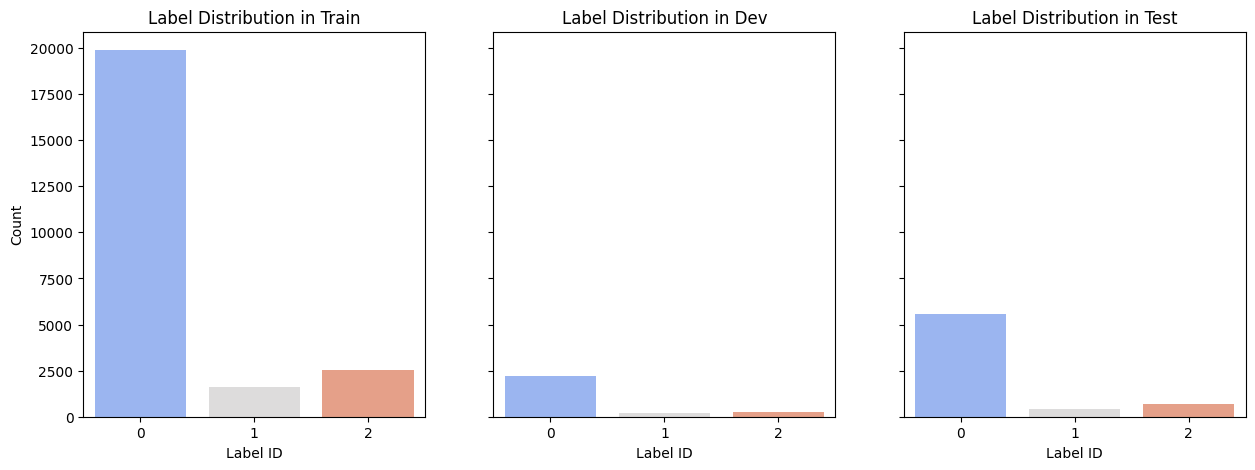

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for idx, (df, title) in enumerate(zip([train_set, dev_set, test_set], ['Train', 'Dev', 'Test'])):
    sns.countplot(x=df['label_id'], ax=axes[idx], palette="coolwarm")
    axes[idx].set_title(f"Label Distribution in {title}")
    axes[idx].set_xlabel("Label ID")
    axes[idx].set_ylabel("Count")

plt.show()

## **IV. Handling Class Imbalance in Train Set**

### **1. Augment Data**

#### **1.1. Back Translate for Class 1&2**

In [25]:
abbreviation_dict = {
    "m": "mày",
    "t": "tao",
    "VN": "Việt Nam",
    "lol, loz": "lồn",
    "vl": "vãi lồn",
    "dmm": "địt mẹ mày",
    "cc": "con cặc",
    "cl": "cái lồn",
    "vc": "vãi cặc",
    "dm": "địt mẹ",
    "vcl": "vãi cả lồn",
    "cmn": "con mẹ nó",
    "mn": "mọi người",
    "k, ko": "không",
    "cmt": "bình luận",
    "ak, ah": "à",
    "j": "gì",
    "bh": "bao giờ",
    "in4": "thông tin",
    "inb, ib": "nhắn tin",
    "dc, đc": "được",
    "clg": "cái lồn gì"
}

In [29]:
def expand_abbreviations(text):
    if not isinstance(text, str):
        return text

    for abbr, full_form in abbreviation_dict.items():
        text = re.sub(rf"\b{re.escape(abbr)}\b", full_form, text, flags=re.IGNORECASE)
    return text

In [31]:
train_set["expanded_text"] = train_set.apply(
    lambda row: expand_abbreviations(row["free_text"]) if row["label_id"] in [1, 2] else row["free_text"],axis=1
)

train_set

<ipython-input-31-dda6d5d7914f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set["expanded_text"] = train_set.apply(


,free_text,label_id,expanded_text
0,Em được làm fan cứng luôn rồi nè ❤️ reaction q...,0,Em được làm fan cứng luôn rồi nè ❤️ reaction q...
1,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...,2,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...
2,Đậu Văn Cường giờ giống thằng sida hơn à,0,Đậu Văn Cường giờ giống thằng sida hơn à
3,CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...,2,CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI Việt Nam. ...
4,Từ lý thuyết đến thực hành là cả 1 câu chuyện ...,0,Từ lý thuyết đến thực hành là cả 1 câu chuyện ...
...,...,...,...
24043,Thả tim cho sự cống hiến của ngài,0,Thả tim cho sự cống hiến của ngài
24044,Thua !,0,Thua !
24045,Ở Việt Nam thì có khánh sky..hải ngoại có trần...,0,Ở Việt Nam thì có khánh sky..hải ngoại có trần...
24046,"1:22 ai lớp du chu cờ moo, Duyên dáng quá cô ơi",0,"1:22 ai lớp du chu cờ moo, Duyên dáng quá cô ơi"


In [33]:
def back_translate(text, src_lang="vi", target_lang="en"):
    try:
        translated = GoogleTranslator(source=src_lang, target=target_lang).translate(text)
        back_translated = GoogleTranslator(source=target_lang, target=src_lang).translate(translated)

        return back_translated
    except Exception as e:
        print(f"Translation Error: {e}")
        return text

In [38]:
def parallel_back_translate(texts):
    with ThreadPoolExecutor(max_workers=4) as executor:
        results = list(executor.map(back_translate, texts))
    return results

In [40]:
back_translate_df = train_set[train_set['label_id'].isin([1, 2])].copy()
back_translate_df['back_translate'] = parallel_back_translate(back_translate_df['expanded_text'].values)

In [41]:
df_augmented = pd.concat([train_set, back_translate_df[['label_id', 'back_translate']].rename(columns={"back_translate": "free_text"})])

In [42]:
df_augmented['label_id'].value_counts()

,count
label_id,
0,19885
2,5112
1,3210


In [43]:
df_augmented

,free_text,label_id,expanded_text
0,Em được làm fan cứng luôn rồi nè ❤️ reaction q...,0,Em được làm fan cứng luôn rồi nè ❤️ reaction q...
1,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...,2,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...
2,Đậu Văn Cường giờ giống thằng sida hơn à,0,Đậu Văn Cường giờ giống thằng sida hơn à
3,CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...,2,CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI Việt Nam. ...
4,Từ lý thuyết đến thực hành là cả 1 câu chuyện ...,0,Từ lý thuyết đến thực hành là cả 1 câu chuyện ...
...,...,...,...
24013,Công nghệ của Cộng sản đã đạt đến cấp độ vượt ...,2,NaN
24016,"Corona đã mất ý thức của bạn, em yêu :)",2,NaN
24027,Tôi không thấy ai bị xử tử ... bởi vì hàng ngh...,1,NaN
24029,Mất hình ảnh của lồn,1,NaN


In [64]:
df_augmented['free_text'].astype(str)

,free_text
0,Em được làm fan cứng luôn rồi nè ❤️ reaction q...
1,Đúng là bọn mắt híp lò xo thụt :))) bên việt n...
2,Đậu Văn Cường giờ giống thằng sida hơn à
3,CÔN ĐỒ CỤC SÚC VÔ NHÂN TÍNH ĐỀ NGHI VN. NHÀ NƯ...
4,Từ lý thuyết đến thực hành là cả 1 câu chuyện ...
...,...
24013,Công nghệ của Cộng sản đã đạt đến cấp độ vượt ...
24016,"Corona đã mất ý thức của bạn, em yêu :)"
24027,Tôi không thấy ai bị xử tử ... bởi vì hàng ngh...
24029,Mất hình ảnh của lồn


#### **1.2. Synonym Replacement**

In [44]:
synonym_dict = {
    "dốt": ["ngu", "đần", "dở"],
    "điên": ["khùng", "ngáo ngơ", "ngớ ngẩn"],
    "xấu": ["tệ"],
    "thằng": ["gã", "thằng cha", "thằng nhãi", "thằng khốn"],
    "cực đoan": ["quá khích", "không kiểm soát"],
    "phản động": ["chống đối", "bất mãn"],
    "ngu": ["đần", "dốt", "khờ", "ngốc", "ngớ ngẩn", "thiểu năng"],
    "đánh": ["tẩn", "đập", "tát", "đấm", "xử", "bạt tai"],
    "chó": ["cẩu", "súc vật", "đồ chó má", "thằng khốn"],
    "vl": ["vãi lồn", "vãi cả đái", "kinh khủng"],
    "dmm": ["địt mẹ mày", "mẹ kiếp mày", "mẹ mày chết"],
    "cút": ["biến", "lượn", "xéo", "cút xéo"],
    "vô học": ["thất học", "dốt nát", "thiếu giáo dục"],
    "ghét": ["căm thù", "không ưa", "khinh", "hận"],
    "lừa": ["dối", "gạt", "lừa đảo", "bẫy", "xỏ mũi"],
}

In [60]:
def replace_synonyms(text):
    if not isinstance(text, str):
        return text

    words = underthesea.word_tokenize(text)
    new_words = []

    for word in words:
        if word in synonym_dict and random.random() < 0.3:
            new_words.append(random.choice(synonym_dict[word]))
        else:
            new_words.append(word)

    return " ".join(new_words)

In [61]:
def parallel_replace_synonyms(texts):
    with ThreadPoolExecutor(max_workers=4) as executor:
        results = list(executor.map(replace_synonyms, texts))
    return results

In [65]:
synonym_replace_df = df_augmented[df_augmented['label_id'].isin([1, 2])].copy()
synonym_replace_df['synonym_replaced_text'] = parallel_replace_synonyms(synonym_replace_df['free_text'].values)

In [66]:
df_augmented = pd.concat([df_augmented, synonym_replace_df[['label_id', 'synonym_replaced_text']].rename(columns={"synonym_replaced_text": "free_text"})])

In [67]:
df_augmented['label_id'].value_counts()

,count
label_id,
0,19885
2,10224
1,6420


#### **1.3. DownSampling for Class 0**

In [68]:
df_majority = df_augmented[df_augmented['label_id'] == 0]
df_minority1 = df_augmented[df_augmented['label_id'] == 1]
df_minority2 = df_augmented[df_augmented['label_id'] == 2]

In [71]:
df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority1) + len(df_minority2),
                                   random_state=42)

In [73]:
train_balanced = pd.concat([df_majority_downsampled, df_minority1, df_minority2])
train_balanced = train_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [74]:
train_balanced['label_id'].value_counts()

,count
label_id,
0,16644
2,10224
1,6420


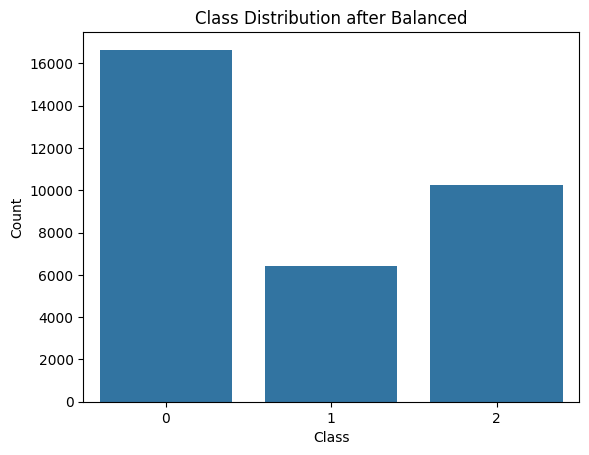

In [75]:
sns.countplot(x=train_balanced['label_id'])
plt.title("Class Distribution after Balanced")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## **V. Text Length Distribution**

In [76]:
train_balanced['text_length'] = train_balanced['free_text'].apply(lambda x: len(str(x).split()))
dev_set['text_length'] = dev_set['free_text'].apply(lambda x: len(str(x).split()))
test_set['text_length'] = test_set['free_text'].apply(lambda x: len(str(x).split()))

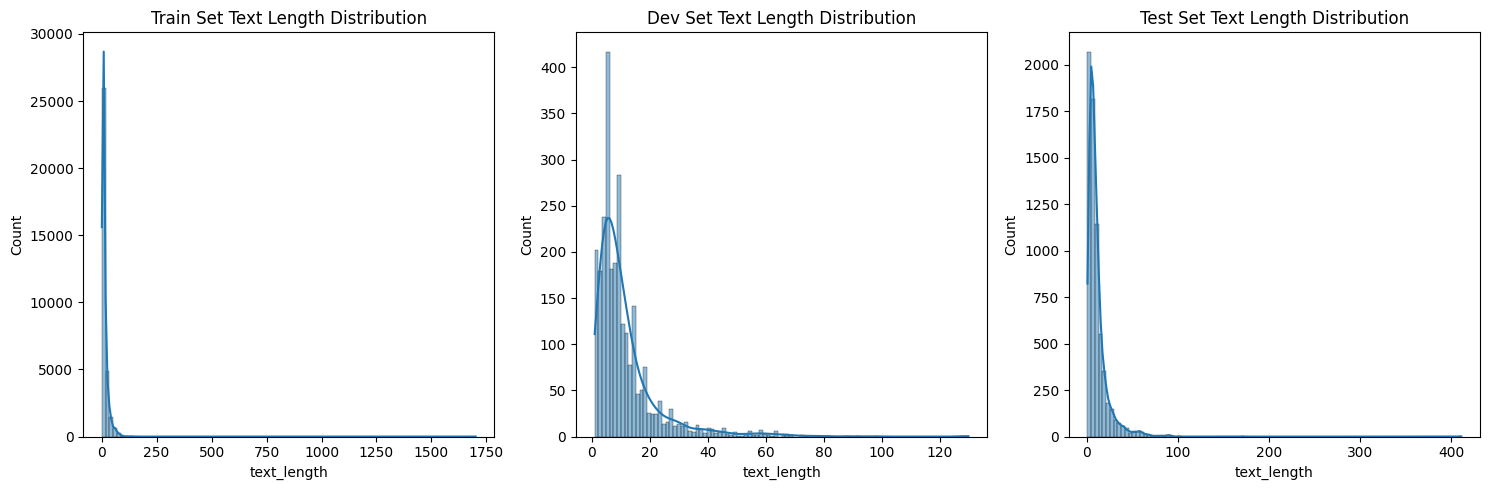

In [77]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(train_balanced['text_length'], bins=100, kde=True)
plt.title('Train Set Text Length Distribution')

plt.subplot(1, 3, 2)
sns.histplot(dev_set['text_length'], bins=100, kde=True)
plt.title('Dev Set Text Length Distribution')

plt.subplot(1, 3, 3)
sns.histplot(test_set['text_length'], bins=100, kde=True)
plt.title('Test Set Text Length Distribution')

plt.tight_layout()
plt.show()


In [83]:
print("Train set:")
print(train_balanced['text_length'].describe())
max_length = int(train_balanced['text_length'].quantile(0.95))
print(f"95th percentile text length: {max_length} words\n")
print("--"*20)

print("Dev set:")
print(dev_set['text_length'].describe())
max_length = int(dev_set['text_length'].quantile(0.95))
print(f"95th percentile text length: {max_length} words\n")
print("--"*20)

print("Test set:")
print(test_set['text_length'].describe())
max_length = int(test_set['text_length'].quantile(0.95))
print(f"95th percentile text length: {max_length} words")

Train set:
count    33288.000000
mean        13.629236
std         19.713702
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max       1701.000000
Name: text_length, dtype: float64
95th percentile text length: 41 words

----------------------------------------
Dev set:
count    2672.000000
mean       11.509356
std        11.709861
min         1.000000
25%         5.000000
50%         8.000000
75%        14.000000
max       130.000000
Name: text_length, dtype: float64
95th percentile text length: 33 words

----------------------------------------
Test set:
count    6680.000000
mean       11.484581
std        12.442907
min         1.000000
25%         5.000000
50%         8.000000
75%        13.000000
max       411.000000
Name: text_length, dtype: float64
95th percentile text length: 33 words


# **B. Preprocessing**

In [90]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [91]:
train_balanced['cleaned_comment'] = train_balanced['free_text'].apply(clean_text)
dev_set['cleaned_comment'] = dev_set['free_text'].apply(clean_text)
test_set['cleaned_comment'] = test_set['free_text'].apply(clean_text)

In [92]:
train_balanced[['free_text', 'label_id', 'cleaned_comment']]

,free_text,label_id,cleaned_comment
0,"Dkm, chan Vkl",1,dkm chan vkl
1,"Khổ a tao, có cái tên suốt ngày bị lấy.",0,khổ a tao có cái tên suốt ngày bị lấy
2,Ủa bữa khóc lóc Xin lỗi rồi giờ chửi tiếp hả,0,ủa bữa khóc lóc xin lỗi rồi giờ chửi tiếp hả
3,Del hài lòng,1,del hài lòng
4,Ơ thật à:)),0,ơ thật à
...,...,...,...
33283,Nhìn khó chịu vch.,1,nhìn khó chịu vch
33284,BenBen Duong,0,benben duong
33285,Đạt Nguyễn chó là bn ko phải thức ăn 😂😂,0,đạt nguyễn chó là bn ko phải thức ăn
33286,Thu đi để lại lá vàng nhunh đến gửi ngàn lời y...,0,thu đi để lại lá vàng nhunh đến gửi ngàn lời y...


In [93]:
train_balanced[['free_text', 'label_id', 'text_length', 'cleaned_comment']].to_csv("/content/drive/MyDrive/raw/processed_train.csv", index=False)
dev_set.to_csv("/content/drive/MyDrive/raw/processed_dev.csv", index=False)
test_set.to_csv("/content/drive/MyDrive/raw/processed_test.csv", index=False)